## 1. Loading the dataset and finding the nature and datatype of attributes

In [79]:
import numpy as np
import pandas as pd
dataset_load = pd.read_excel('./datasetcorrected.xlsx',header=2)
dataset_load.head()

,Reading#,Mote ID,Humidity,Tepmrature,Label
0,1.0,1.0,43.82,30.21,0.0
1,2.0,1.0,43.79,30.20,0.0
2,3.0,1.0,43.79,30.19,0.0
3,4.0,1.0,43.79,30.19,0.0
4,5.0,1.0,43.79,30.19,0.0


In [80]:
dataset_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4700 entries, 0 to 4699
Data columns (total 5 columns):
Reading#      4690 non-null float64
Mote ID       4690 non-null float64
Humidity      4690 non-null float64
Tepmrature    4690 non-null float64
Label         4690 non-null float64
dtypes: float64(5)
memory usage: 183.7 KB


The above data contains 5 columns and the nature of the columns can be expressed in 2 categories which I have discussed briefly in above document. Other than that the datatype for the columns is float and maximum entries are non-null. The data problem is addressed in the Section Below.

## 2. Solving Data Problem

### Checking Columns for Irregularities

In [81]:
dataset_load.columns

Index(['Reading#', 'Mote ID', 'Humidity', 'Tepmrature', 'Label'], dtype='object')

### Correction of Reading# and temperature spelling

In [82]:
dataset_load.columns=["Reading","Mote ID","Humidity","Temperature","Label"]
dataset_load.head()

,Reading,Mote ID,Humidity,Temperature,Label
0,1.0,1.0,43.82,30.21,0.0
1,2.0,1.0,43.79,30.20,0.0
2,3.0,1.0,43.79,30.19,0.0
3,4.0,1.0,43.79,30.19,0.0
4,5.0,1.0,43.79,30.19,0.0


### Checking the Missing Values in Dataset

In [83]:
dataset_load = dataset_load.replace('?',np.NaN)

print('Number of instances = %d' % (dataset_load.shape[0]))
print('Number of attributes = %d' % (dataset_load.shape[1]))

print('Number of missing values:')
for col in dataset_load.columns:
    print('\t%s: %d' % (col,dataset_load[col].isna().sum()))

Number of instances = 4700
Number of attributes = 5
Number of missing values:
	Reading: 10
	Mote ID: 10
	Humidity: 10
	Temperature: 10
	Label: 10


### Removing the missing values as we have equal number of missing values

In [84]:
print('Number of rows in original data = %d' % (dataset_load.shape[0]))
dataset_clean = dataset_load.dropna()
print('Number of rows after discarding missing values = %d' % (dataset_clean.shape[0]))

Number of rows in original data = 4700
Number of rows after discarding missing values = 4690


### Checking Duplicate data

In [85]:
duplicated = dataset_clean.duplicated()
print('Number of duplicate rows = %d' % (duplicated.sum()))

Number of duplicate rows = 0


### Outlier Detection using the Z-score criteria
Here we check whether the z score is between -3 and 3

In [86]:
Z = (dataset_clean-dataset_clean.mean())/dataset_clean.std()
print('Before Outliers detection= %d' % (Z.shape[0]))

Z2 = Z.loc[((Z > -1.5).sum(axis=1)==9) & ((Z <= 1.5).sum(axis=1)==9),:]
print('Discarded Outlier Values = %d' % (Z2.shape[0]))

Before Outliers detection= 4690
Discarded Outlier Values = 0


### Plotting The Dataset

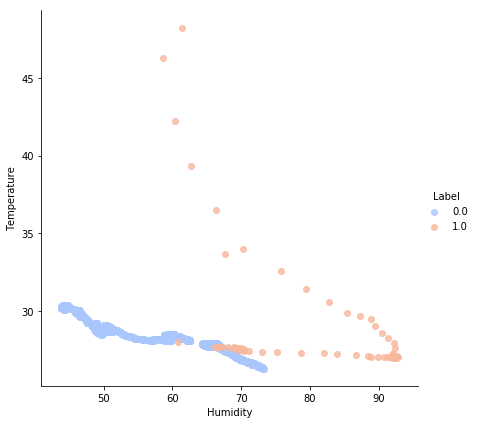

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.lmplot(x='Humidity',y='Temperature',data=dataset_clean, hue='Label', palette='coolwarm', fit_reg=False, height=6, aspect=1)

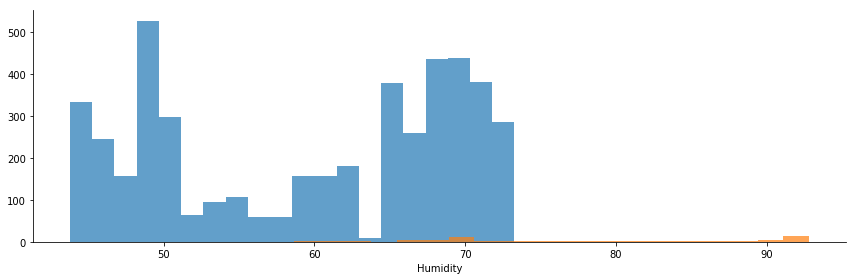

In [88]:
humidity_bar = sns.FacetGrid(dataset_clean, hue='Label', height=4, aspect=3)
humidity_bar.map(plt.hist,'Humidity',bins=20,alpha=0.7)

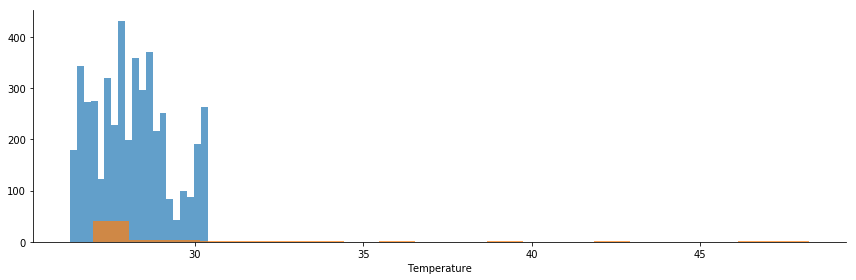

In [89]:
temperature_bar = sns.FacetGrid(dataset_clean, hue='Label', height=4, aspect=3)
temperature_bar.map(plt.hist,'Temperature',bins=20,alpha=0.7)

## Taking out the Label and Clustering the rest of Data with K-means Algorithm
Here we are ruling out the data to be clustered and the actual value of label. This will help us to understand the accuracy of our algorithm. To increase the accuracy we have scaled our value in the range -1 to 1.Our values of temperature and pressure were large and we visualised the difference between various labels designated.

In [210]:
to_cluster = np.array(dataset_clean.drop(['Label'], 1).astype(float))
label_value=np.array(dataset_clean['Label'])

In [211]:
from sklearn.preprocessing import MinMaxScaler
scaled_data = MinMaxScaler()
to_cluster = scaled_data.fit_transform(to_cluster)

In [215]:
from sklearn.cluster import KMeans
k_means_instance = KMeans(n_clusters = 2,max_iter=600,algorithm='full')
k_means_instance.fit(to_cluster)
k_means_instance.cluster_centers_

array([[0.72993365, 0.        , 0.49817576, 0.04706368, 0.        ],
       [0.22998519, 0.        , 0.1289633 , 0.12817853, 0.        ]])

### Accuracy Determination using Confusion matrix and Classification Report

In [216]:
from sklearn.metrics import classification_report, confusion_matrix
c_matrix=confusion_matrix(label_value,k_means_instance.labels_)
c_matrix

array([[2478, 2154],
       [  55,    3]], dtype=int64)

In [217]:
sum_true= c_matrix[0][0]+c_matrix[1][1]
sum_all = c_matrix[0][0]+c_matrix[0][1]+c_matrix[1][0]+c_matrix[1][1]
accuracy= sum_true/sum_all
accuracy*100

52.89978678038379

Let us interpret the result provided by the above confusion Matrix. The matrix is in the way of True Negatives, False Positives and in second row False Negatives and true Positives.Thus when we infer this we have 4632 records of one label and 58 records of the other label.Thus for the first row or label we have 2478 records correctly labelled or correct True Negatives identified. 2154 was the false positive result. Whereas in the second row we have 55 False Positives and 1 True Negative. Overall , we have 2481 records correctly marked after clustering. More Information in the Document Above.

###  Evaluation of Anomaly Detection for K-Means Algorithm

In [116]:
print(classification_report(label_value,k_means_instance.labels_))

              precision    recall  f1-score   support

         0.0       0.98      0.53      0.69      4632
         1.0       0.00      0.05      0.00        58

   micro avg       0.53      0.53      0.53      4690
   macro avg       0.49      0.29      0.35      4690
weighted avg       0.97      0.53      0.68      4690



For the classification report we can see our positive prediction accuracy for both 0 and 1 labels. The amount of positive instances identified is in the recall and combininig both these metrics we get f1-score which is also at 68 percent overall. But the amount for the labels 1 is less due to the amount of records present for that particular label.

## Hierarchial Clustering Using Agglomerative Clustering
Here we are choosing the temperature and humidity features as those are the important features for determination whether the data is normal or an anomaly

In [124]:
clustering_data=dataset_clean.iloc[:, 2:4].values
clustering_data

array([[43.82, 30.21],
       [43.79, 30.2 ],
       [43.79, 30.19],
       ...,
       [73.23, 26.33],
       [73.17, 26.33],
       [73.15, 26.34]])

#### Scaling the dataset so that algorithm performance increases and the graphs can fit the model

In [148]:
from sklearn.preprocessing import MinMaxScaler
clustering_data_scaled = MinMaxScaler()
clustering_data_scaled = scaled_data.fit_transform(clustering_data)

### Plotting a dendogram for determination of clusters

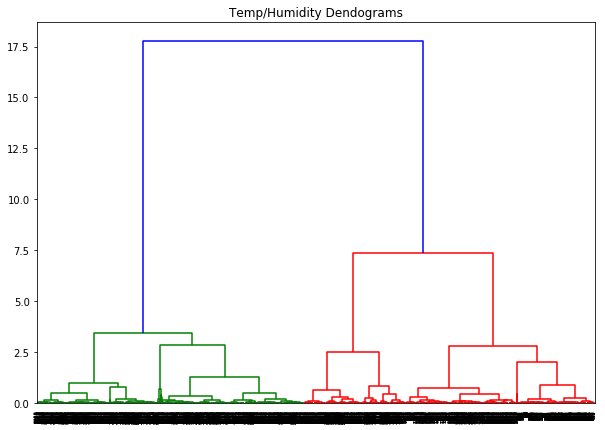

In [149]:
import scipy.cluster.hierarchy as clusterdiagram
plt.figure(figsize=(10, 7))  
plt.title("Temp/Humidity Dendograms")  
dend = clusterdiagram.dendrogram(shc.linkage(clustering_data_scaled, method='ward'))  

### Applying Agglomerative clustering using the clusters found from the above step

In [218]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
cls=cluster.fit_predict(clustering_data_scaled)
cls

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

### Plotting the Agglomerative clusters on a graph

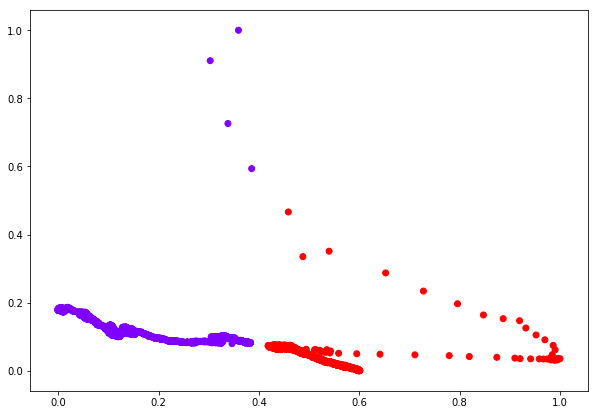

In [219]:
plt.figure(figsize=(10, 7))  
plt.scatter(clustering_data_scaled[:,0], clustering_data_scaled[:,1], c=cluster.labels_, cmap='rainbow')

### Determining the accuracy of the algorithm using the same confusion matrix and classification report

In [221]:
from sklearn.metrics import classification_report, confusion_matrix
c_matrix=confusion_matrix(np.array(dataset_clean['Label']),cls)
c_matrix

array([[2440, 2192],
       [   5,   53]], dtype=int64)

In [222]:
sum_true= c_matrix[0][0]+c_matrix[1][1]
sum_all = c_matrix[0][0]+c_matrix[0][1]+c_matrix[1][0]+c_matrix[1][1]
accuracy= sum_true/sum_all
accuracy*100

53.15565031982943

Here we have 2493 positive results and 2197 negative results. In positive results we have true negatives and true positives whereas in false result we have false positive and false negative. 

###  Evaluation of Anomaly Detection for Agglomerative Algorithm

In [177]:
print(classification_report(np.array(dataset_clean['Label']),cls))

              precision    recall  f1-score   support

         0.0       1.00      0.53      0.69      4632
         1.0       0.02      0.91      0.05        58

   micro avg       0.53      0.53      0.53      4690
   macro avg       0.51      0.72      0.37      4690
weighted avg       0.99      0.53      0.68      4690



Here we have improved numbers for the precision, recall and the f1 score. especially the precision and f1 score have shown a noticable improvement. But we should also consider the fact that recall have shown improvement in the macro average. Overall the accuracy of this algorithm have improved.

## Applying DBSCAN algorithm with the previously scaled values

In [232]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=0.2, metric='euclidean', min_samples=5)
clusters = dbs.fit(clustering_data_scaled)
clusters.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Analysing the Principle Component and transforming the scaled data into PCA array

In [233]:
from sklearn.decomposition import PCA
component_analysis = PCA(n_components=2).fit(clustering_data_scaled)
analysed_components = pca.transform(clustering_data_scaled)
analysed_components

array([[-0.34056168,  0.01788037],
       [-0.3410553 ,  0.01729849],
       [-0.34095256,  0.01685464],
       ...,
       [ 0.28392451, -0.0190106 ],
       [ 0.2827318 , -0.01928667],
       [ 0.2822315 , -0.01893485]])

In [234]:
analysed_components.shape

(4690, 2)

### Plotting the Clusters found using DBSCAN algorithm with the help of PCA array and Visualising the Anomaly

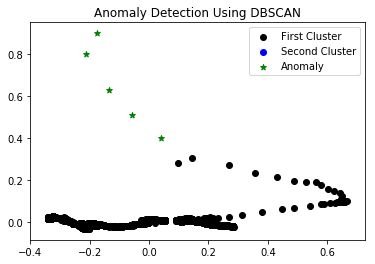

In [247]:
import matplotlib.pyplot as plt
for i in range(0,analysed_components.shape[0]):
    if clusters.labels_[i] == 0:
        cluster1 = plt.scatter(analysed_components[i, 0], analysed_components[i, 1], c='black', marker='o')
    elif clusters.labels_[i] == 1:
        cluster2 = plt.scatter(analysed_components[i, 0], analysed_components[i, 1], c='blue', marker='o')
    elif clusters.labels_[i] == -1:
        cluster3 = plt.scatter(analysed_components[i, 0], analysed_components[i, 1], c='green', marker='*')
plt.legend([cluster1, cluster2, cluster3], ['First Cluster', 'Second Cluster', 'Anomaly'])
plt.title('Anomaly Detection Using DBSCAN')
plt.show()

### Calculating the accuracy using the same metric we used for other 2 Algorithms

In [238]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(np.array(dataset_clean['Label']),clusters.labels_))

[[   0    0    0]
 [   0 4632    0]
 [   5   53    0]]


In [242]:
print(classification_report(np.array(dataset_clean['Label']),clusters.labels_))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.99      1.00      0.99      4632
         1.0       0.00      0.00      0.00        58

   micro avg       0.99      0.99      0.99      4690
   macro avg       0.33      0.33      0.33      4690
weighted avg       0.98      0.99      0.98      4690



C:\Users\chand\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\chand\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\chand\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\chand\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\chand\Anaconda3\lib\sit

### Removing the Error and Getting fair values of Accuracy
Here the labels were divided into 3 types which was causing the error as in actual data we have only 2 of the labels. Thus we are equalising the -1 labels which is an outlier with the label 1 which is the actual outlier data in the dataset.

In [243]:
cluster_array=[]
for i in range(len(clusters.labels_)):
    if clusters.labels_[i]== -1:
        cluster_array.insert(i, 1)
    else:
        cluster_array.insert(i,clusters.labels_[i])

### Calculating the accuracy again and checking the confusion matrix and classification report

In [244]:
c_matrix=confusion_matrix(np.array(dataset_clean['Label']),cluster_array)
c_matrix

array([[4632,    0],
       [  53,    5]], dtype=int64)

In [245]:
sum_true= c_matrix[0][0]+c_matrix[1][1]
sum_all = c_matrix[0][0]+c_matrix[0][1]+c_matrix[1][0]+c_matrix[1][1]
accuracy= sum_true/sum_all
accuracy*100

98.86993603411514

###  Evaluation of Anomaly Detection for DBSCAN Algorithm

In [246]:
print(classification_report(np.array(dataset_clean['Label']),cluster_array))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      4632
         1.0       1.00      0.09      0.16        58

   micro avg       0.99      0.99      0.99      4690
   macro avg       0.99      0.54      0.58      4690
weighted avg       0.99      0.99      0.98      4690



Classification report is much higher than the previous 2 algorithms and the recall , f1 score values have improved tremendously.But we have got this result on the basis that the outlier detected as -1 are all 1 in the actual data. If this is not the consideration this algorithm have shown improvement but until a certain extent only.